# Using ChatGPT with the Semantic Kernel featuring DALL-E 2

This notebook shows how to make use of the new ChatCompletion API from OpenAI, popularized by ChatGPT. This API brings a new ChatML schema which is different from the TextCompletion API that we've featured so far in other notebooks. While the text completion API expects input a prompt and returns a simple string, the chat completion API expects in input a Chat history and returns a new message:

```
messages=[
    { "role": "system",    "content": "You are a helpful assistant."},
    { "role": "user",      "content": "Who won the world series in 2020?"},
    { "role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    { "role": "user",      "content": "Where was it played?"}
]
```

Note that there are three message types:

1. A System message is used to give instructions to the chat model, e.g. setting the context and the kind of conversation your app is offering.
2. User messages store the data received from the user of your app.
3. Assistant messages store the replies generated by the LLM model. 

Your app is responsible for adding information to the chat history and maintaining this object. The Chat Completion API is stateless, and returns only new messages, that your app can use, e.g. to execute commands, generate images, or simply continue the conversation.

When deciding between which one to use, know that ChatGPT models (i.e. gpt-3.5-turbo) are optimized for chat applications and have been fine-tuned for instruction-following and dialogue. As such, for creating semantic skills with the Semantic Kernel, users may still find the TextCompletion model better suited for certain use cases.

The code below shows how to setup SK with ChatGPT, how to manage the Chat history object, and to make things a little more interesting asks ChatGPT to reply with image descriptions instead so we can have a dialog using images, leveraging DALL-E 2 integration.

In [1]:
// Usual setup: importing Semantic Kernel SDK and SkiaSharp, used to display images inline.

#r "nuget: Microsoft.SemanticKernel, 1.0.0-beta"
#r "nuget: SkiaSharp, 2.88.3"

#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.AI.ImageGeneration;
using Microsoft.SemanticKernel.AI.ChatCompletion;

Installed Packages Microsoft.SemanticKernel, 1.0.0-beta1 SkiaSharp, 2.88.3

The notebook uses:

* **OpenAI ChatGPT** to chat with the user
* **OpenAI Dall-E 2** to transform messages into images

In [2]:
// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

// Configure the two AI features: OpenAI Chat and DALL-E 2 for image generation
var builder = new KernelBuilder();

if(useAzureOpenAI)
{
    builder.WithAzureChatCompletionService("gpt-35-turbo", azureEndpoint, apiKey);
    builder.WithAzureOpenAIImageGenerationService(azureEndpoint, apiKey);
}
else
{
    builder.WithOpenAIChatCompletionService("gpt-3.5-turbo", apiKey, orgId);
    builder.WithOpenAIImageGenerationService(apiKey, orgId);
}

var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetService<IImageGeneration>();

// Get AI service instance used to manage the user chat
var chatGPT = kernel.GetService<IChatCompletion>();

# Chat configuration

Before starting the chat, we create a new chat object with some instructions, which are included in the chat history. 

The instructions tell OpenAI what kind of chat we want to have, in this case we ask to reply with "image descriptions", so that we can chain ChatGPT with DALL-E 2.

In [3]:
using Microsoft.SemanticKernel.Connectors.AI.OpenAI.ChatCompletion;

var systemMessage = "You're chatting with a user. Instead of replying directly to the user"
                  + " provide a description of a cartoonish image that expresses what you want to say."
                  + " The user won't see your message, they will see only the image."
                  + " Describe the image with details in one sentence.";

var chat = (OpenAIChatHistory)chatGPT.CreateNewChat(systemMessage);

# Let's chat

Run the following code to start the chat. The chat consists of a loop with these main steps:

1. Ask the user (you) for a message. The user enters a message. Add the user message into the Chat History object.
2. Send the chat object to AI asking to generate a response. Add the bot message into the Chat History object.
3. Show the answer to the user. In our case before showing the answer, generate an image and show that to the user too.

*Note: to stop the chat in VS Code press ESC on the kyboard or the "stop" button on the left side.*

User: cute cat

Bot:



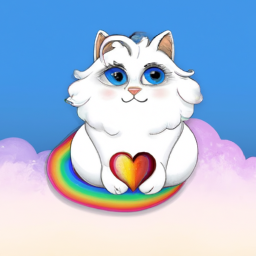

[A fluffy white cat with big blue eyes and a pink nose, sitting on a rainbow-colored cloud and holding a tiny heart in its paws.]



Error: Input request cancelled

Error: Input request cancelled

Error: System.Exception: Input request cancelled
   at Microsoft.DotNet.Interactive.Kernel.GetInputAsync(String prompt, Boolean isPassword, String typeHint, String valueName) in D:\a\_work\1\s\src\Microsoft.DotNet.Interactive\Kernel.Static.cs:line 72
   at Microsoft.DotNet.Interactive.Kernel.GetInputAsync(String prompt, String typeHint, String valueName) in D:\a\_work\1\s\src\Microsoft.DotNet.Interactive\Kernel.Static.cs:line 46
   at Submission#10.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)

In [5]:
while (true)
{
    // 1. Ask the user for a message. The user enters a message.  Add the user message into the Chat History object.
    var userMessage = await InteractiveKernel.GetInputAsync("Your message");
    Console.WriteLine($"User: {userMessage}");
    chat.AddUserMessage(userMessage);

    // 2. Send the chat object to AI asking to generate a response. Add the bot message into the Chat History object.
    string assistantReply = await chatGPT.GenerateMessageAsync(chat);
    chat.AddAssistantMessage(assistantReply);

    // 3. Show the reply as an image
    Console.WriteLine($"\nBot:");
    var imageUrl = await dallE.GenerateImageAsync(assistantReply, 256, 256);
    await SkiaUtils.ShowImage(imageUrl, 256, 256);
    Console.WriteLine($"[{assistantReply}]\n");
}